In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_medium_aug_k_2_focal_patch64'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_medium_aug_k_2_focal_patch64',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (

In [9]:
model_config['encoder_name'] = 'resnet50'
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 1e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 1e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'medium'
aug_config['k'] = 2
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'medium', 'original_height': 64, 'original_width': 64, 'k': 2}

In [12]:
loss_config =[
    {
        'loss': 'Focal', 
        'weight': 1, 
        'params': {
            'alpha': 0.5,
            'gamma': 2
        }
    },
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'Focal', 'weight': 1, 'params': {'alpha': 0.5, 'gamma': 2}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 256
dataloaders_conf['val']['batch_size'] = 256
dataloaders_conf['test']['batch_size'] = 256
dataloaders_conf

{'train': {'batch_size': 256, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 256, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 256, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 664.95it/s]
100%|██████████| 720/720 [00:07<00:00, 92.93it/s] 
33120it [00:00, 235389.90it/s]
31680it [00:00, 166900.99it/s]
700it [00:00, 875.39it/s]
100%|██████████| 700/700 [00:06<00:00, 100.67it/s]
27830it [00:00, 137779.01it/s]
26620it [00:00, 239436.03it/s]
710it [00:00, 855.44it/s]
100%|██████████| 710/710 [00:07<00:00, 96.45it/s] 
31680it [00:00, 143114.38it/s]
30240it [00:00, 127592.76it/s]
720it [00:00, 828.27it/s]
100%|██████████| 720/720 [00:07<00:00, 95.57it/s] 
33120it [00:00, 246330.01it/s]
720it [00:00, 839.96it/s]
100%|██████████| 720/720 [00:07<00:00, 94.78it/s] 
103680it [00:00, 161585.23it/s]
700it [00:01, 680.31it/s]
100%|██████████| 700/700 [00:07<00:00, 99.72it/s] 
84700it [00:00, 208723.21it/s]
509it [00:00, 1149.55it/s]
100%|██████████| 509/509 [00:02<00:00, 189.83it/s]
32576it [00:00, 86180.76it/s]
700it [00:00, 809.27it/s]
100%|██████████| 700/700 [00:07<00:00, 99.23it/s] 
84700it [00:00, 216533.18it/s]
700it [00:00, 799.09it/s]
100%|██████████|

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.097246


100%|██████████| 346/346 [00:30<00:00, 11.48it/s]


Mean val loss: 0.033957


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.040776


100%|██████████| 346/346 [00:31<00:00, 11.03it/s]


Mean val loss: 0.024699


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.036578


100%|██████████| 346/346 [00:30<00:00, 11.19it/s]


Mean val loss: 0.017742


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.034905


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02986
EarlyStopping counter: 1 out of 15
Epoch 4...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.034059


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01885
EarlyStopping counter: 2 out of 15
Epoch 5...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.03325


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.020453
EarlyStopping counter: 3 out of 15
Epoch 6...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.03303


100%|██████████| 346/346 [00:30<00:00, 11.39it/s]


Mean val loss: 0.013834


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.032643


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.022188
EarlyStopping counter: 1 out of 15
Epoch 8...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.032611


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.015167
EarlyStopping counter: 2 out of 15
Epoch 9...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.032234


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.018732
EarlyStopping counter: 3 out of 15
Epoch 10...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.032061


100%|██████████| 346/346 [00:30<00:00, 11.38it/s]


Mean val loss: 0.013164


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 11...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.031719


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013976
EarlyStopping counter: 1 out of 15
Epoch 12...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.031339


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01776
EarlyStopping counter: 2 out of 15
Epoch 13...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.031135


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01372
EarlyStopping counter: 3 out of 15
Epoch 14...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030868


100%|██████████| 346/346 [00:30<00:00, 11.41it/s]


Mean val loss: 0.013157


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030791


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.038141
EarlyStopping counter: 1 out of 15
Epoch 16...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030587


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.014473
EarlyStopping counter: 2 out of 15
Epoch 17...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030494


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.022853
EarlyStopping counter: 3 out of 15
Epoch 18...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030825


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013782
EarlyStopping counter: 4 out of 15
Epoch 19...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.03077


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013502
EarlyStopping counter: 5 out of 15
Epoch 20...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030513


100%|██████████| 346/346 [00:30<00:00, 11.42it/s]


Mean val loss: 0.012593


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030218


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.015648
EarlyStopping counter: 1 out of 15
Epoch 22...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030231


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013003
EarlyStopping counter: 2 out of 15
Epoch 23...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030051


100%|██████████| 346/346 [00:30<00:00, 11.17it/s]


Mean val loss: 0.01202


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 24...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030066


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.020709
EarlyStopping counter: 1 out of 15
Epoch 25...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029925


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.011644


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 26...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029904


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011919
EarlyStopping counter: 1 out of 15
Epoch 27...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029865


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012525
EarlyStopping counter: 2 out of 15
Epoch 28...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029757


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01173
EarlyStopping counter: 3 out of 15
Epoch 29...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029659


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.020528
EarlyStopping counter: 4 out of 15
Epoch 30...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029752


100%|██████████| 346/346 [00:30<00:00, 11.42it/s]


Mean val loss: 0.011506


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 31...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029586


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011884
EarlyStopping counter: 1 out of 15
Epoch 32...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029457


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.018172
EarlyStopping counter: 2 out of 15
Epoch 33...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029562


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.019151
EarlyStopping counter: 3 out of 15
Epoch 34...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029605


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012196
EarlyStopping counter: 4 out of 15
Epoch 35...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029571


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012265
EarlyStopping counter: 5 out of 15
Epoch 36...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029437


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.021147
EarlyStopping counter: 6 out of 15
Epoch 37...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029383


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01273
EarlyStopping counter: 7 out of 15
Epoch 38...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029468


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011728
EarlyStopping counter: 8 out of 15
Epoch 39...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029377


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.011412


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 40...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029444


100%|██████████| 346/346 [00:30<00:00, 11.33it/s]


Mean val loss: 0.011299


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029347


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012291
EarlyStopping counter: 1 out of 15
Epoch 42...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029356


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012661
EarlyStopping counter: 2 out of 15
Epoch 43...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02929


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013935
EarlyStopping counter: 3 out of 15
Epoch 44...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029273


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.018047
EarlyStopping counter: 4 out of 15
Epoch 45...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029252


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011482
EarlyStopping counter: 5 out of 15
Epoch 46...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029236


100%|██████████| 346/346 [00:30<00:00, 11.35it/s]


Mean val loss: 0.011277


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 47...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02927


100%|██████████| 346/346 [00:30<00:00, 11.43it/s]


Mean val loss: 0.011245


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 48...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02917


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011728
EarlyStopping counter: 1 out of 15
Epoch 49...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029038


100%|██████████| 346/346 [00:30<00:00, 11.30it/s]


Mean val loss: 0.011181


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02917


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01134
EarlyStopping counter: 1 out of 15
Epoch 51...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029189


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01207
EarlyStopping counter: 2 out of 15
Epoch 52...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029223


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011284
EarlyStopping counter: 3 out of 15
Epoch 53...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029191


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013052
EarlyStopping counter: 4 out of 15
Epoch 54...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02922


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.034123
EarlyStopping counter: 5 out of 15
Epoch 55...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029014


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011346
EarlyStopping counter: 6 out of 15
Epoch 56...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029068


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012334
EarlyStopping counter: 7 out of 15
Epoch 57...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028999


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011558
EarlyStopping counter: 8 out of 15
Epoch 58...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029019


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012232
EarlyStopping counter: 9 out of 15
Epoch 59...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029018


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011212
EarlyStopping counter: 10 out of 15
Epoch 60...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029001


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.011123


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 61...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029054


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011674
EarlyStopping counter: 1 out of 15
Epoch 62...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029033


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013715
EarlyStopping counter: 2 out of 15
Epoch 63...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029022
Epoch    63: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012891
EarlyStopping counter: 3 out of 15
Epoch 64...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028875


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.016634
EarlyStopping counter: 4 out of 15
Epoch 65...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028768


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.010995


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 66...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028871


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011257
EarlyStopping counter: 1 out of 15
Epoch 67...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028781


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.021111
EarlyStopping counter: 2 out of 15
Epoch 68...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028836


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.010941


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 69...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028848


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011447
EarlyStopping counter: 1 out of 15
Epoch 70...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028972


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011206
EarlyStopping counter: 2 out of 15
Epoch 71...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028869
Epoch    71: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011205
EarlyStopping counter: 3 out of 15
Epoch 72...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028743


100%|██████████| 346/346 [00:30<00:00, 11.27it/s]


Mean val loss: 0.010931


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 73...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028782


100%|██████████| 346/346 [00:30<00:00, 11.31it/s]


Mean val loss: 0.010924


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 74...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028706


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011357
EarlyStopping counter: 1 out of 15
Epoch 75...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028711


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011046
EarlyStopping counter: 2 out of 15
Epoch 76...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028717


100%|██████████| 346/346 [00:30<00:00, 11.21it/s]


Mean val loss: 0.010915


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 77...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028737


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010926
EarlyStopping counter: 1 out of 15
Epoch 78...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028739


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010917
EarlyStopping counter: 2 out of 15
Epoch 79...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028799


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010931
EarlyStopping counter: 3 out of 15
Epoch 80...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028694


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010992
EarlyStopping counter: 4 out of 15
Epoch 81...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028758


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010924
EarlyStopping counter: 5 out of 15
Epoch 82...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028687


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012149
EarlyStopping counter: 6 out of 15
Epoch 83...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028711


100%|██████████| 346/346 [00:30<00:00, 11.35it/s]


Mean val loss: 0.010902


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 84...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028717


100%|██████████| 346/346 [00:30<00:00, 11.22it/s]


Mean val loss: 0.010898


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 85...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028646


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010914
EarlyStopping counter: 1 out of 15
Epoch 86...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028761


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010961
EarlyStopping counter: 2 out of 15
Epoch 87...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02862


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01091
EarlyStopping counter: 3 out of 15
Epoch 88...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028586


100%|██████████| 346/346 [00:30<00:00, 11.39it/s]


Mean val loss: 0.010885


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 89...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028641


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010895
EarlyStopping counter: 1 out of 15
Epoch 90...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028785


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010888
EarlyStopping counter: 2 out of 15
Epoch 91...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028669


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011014
EarlyStopping counter: 3 out of 15
Epoch 92...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028587


100%|██████████| 346/346 [00:30<00:00, 11.31it/s]


Mean val loss: 0.010873


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 93...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028664


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010883
EarlyStopping counter: 1 out of 15
Epoch 94...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028675
Epoch    94: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010907
EarlyStopping counter: 2 out of 15
Epoch 95...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028547


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.01084


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 96...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02862


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010861
EarlyStopping counter: 1 out of 15
Epoch 97...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028538


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010865
EarlyStopping counter: 2 out of 15
Epoch 98...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028631


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010845
EarlyStopping counter: 3 out of 15
Epoch 99...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028662


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010871
EarlyStopping counter: 4 out of 15
Epoch 100...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028576


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01085
EarlyStopping counter: 5 out of 15
Epoch 101...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028608


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010912
EarlyStopping counter: 6 out of 15
Epoch 102...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028584


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010851
EarlyStopping counter: 7 out of 15
Epoch 103...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028677
Epoch   103: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 346/346 [00:30<00:00, 11.30it/s]


Mean val loss: 0.010837


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 104...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028613


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010843
EarlyStopping counter: 1 out of 15
Epoch 105...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028518


100%|██████████| 346/346 [00:30<00:00, 11.36it/s]


Mean val loss: 0.010829


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 106...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028649


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.010827


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 107...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028553


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.01084
EarlyStopping counter: 1 out of 15
Epoch 108...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028489


100%|██████████| 346/346 [00:30<00:00, 11.33it/s]


Mean val loss: 0.010826


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 109...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028577


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010829
EarlyStopping counter: 1 out of 15
Epoch 110...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028542


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010829
EarlyStopping counter: 2 out of 15
Epoch 111...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028606


100%|██████████| 346/346 [00:31<00:00, 11.15it/s]


Mean val loss: 0.010824


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 112...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02866


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.010822


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 113...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028562


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010834
EarlyStopping counter: 1 out of 15
Epoch 114...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028574
Epoch   114: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 346/346 [00:30<00:00, 11.31it/s]


Mean val loss: 0.010821


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 115...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028502


100%|██████████| 346/346 [00:30<00:00, 11.29it/s]


Mean val loss: 0.010821


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 116...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028702


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010827
EarlyStopping counter: 1 out of 15
Epoch 117...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028549


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.010821


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 118...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028695


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010822
EarlyStopping counter: 1 out of 15
Epoch 119...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028508


100%|██████████| 346/346 [00:30<00:00, 11.37it/s]


Mean val loss: 0.010818


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 120...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028548
Epoch   120: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010837
EarlyStopping counter: 1 out of 15
Epoch 121...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028546


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010821
EarlyStopping counter: 2 out of 15
Epoch 122...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028603


100%|██████████| 346/346 [00:30<00:00, 11.39it/s]


Mean val loss: 0.010818


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 123...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028574


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010824
EarlyStopping counter: 1 out of 15
Epoch 124...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028471


100%|██████████| 346/346 [00:30<00:00, 11.38it/s]


Mean val loss: 0.010816


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 125...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028511


100%|██████████| 346/346 [00:30<00:00, 11.29it/s]


Mean val loss: 0.010815


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 126...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028358


100%|██████████| 346/346 [00:31<00:00, 11.12it/s]


Mean val loss: 0.010814


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 127...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028556


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010818
EarlyStopping counter: 1 out of 15
Epoch 128...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028486


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010816
EarlyStopping counter: 2 out of 15
Epoch 129...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02858


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010817
EarlyStopping counter: 3 out of 15
Epoch 130...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028572


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010822
EarlyStopping counter: 4 out of 15
Epoch 131...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028484


100%|██████████| 346/346 [00:30<00:00, 11.38it/s]


Mean val loss: 0.010814


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 132...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028622
Epoch   132: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010819
EarlyStopping counter: 1 out of 15
Epoch 133...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02852


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010818
EarlyStopping counter: 2 out of 15
Epoch 134...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028582


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010821
EarlyStopping counter: 3 out of 15
Epoch 135...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028542


100%|██████████| 346/346 [00:30<00:00, 11.31it/s]


Mean val loss: 0.010814


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 136...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028567


100%|██████████| 346/346 [00:30<00:00, 11.30it/s]


Mean val loss: 0.010815


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 137...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028577


100%|██████████| 346/346 [00:30<00:00, 11.36it/s]


Mean val loss: 0.010815


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 138...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028565
Epoch   138: reducing learning rate of group 0 to 3.9063e-06.


100%|██████████| 346/346 [00:30<00:00, 11.35it/s]


Mean val loss: 0.010816


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 139...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028559


100%|██████████| 346/346 [00:30<00:00, 11.33it/s]


Mean val loss: 0.010815


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 140...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028517


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010816
EarlyStopping counter: 1 out of 15
Epoch 141...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028569


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010817
EarlyStopping counter: 2 out of 15
Epoch 142...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02858


100%|██████████| 346/346 [00:30<00:00, 11.36it/s]


Mean val loss: 0.010816


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 143...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028482


100%|██████████| 346/346 [00:30<00:00, 11.33it/s]


Mean val loss: 0.010815


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 144...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028549
Epoch   144: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010816
EarlyStopping counter: 1 out of 15
Epoch 145...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028548


100%|██████████| 346/346 [00:30<00:00, 11.29it/s]


Mean val loss: 0.010812


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 146...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028493


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 1 out of 15
Epoch 147...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028592


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010816
EarlyStopping counter: 2 out of 15
Epoch 148...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028643


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 3 out of 15
Epoch 149...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028598


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 4 out of 15
Epoch 150...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028486
Epoch   150: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 346/346 [00:30<00:00, 11.26it/s]


Mean val loss: 0.010812


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 151...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028464


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 1 out of 15
Epoch 152...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028562


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 2 out of 15
Epoch 153...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028446


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 3 out of 15
Epoch 154...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028477


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010815
EarlyStopping counter: 4 out of 15
Epoch 155...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028598


100%|██████████| 346/346 [00:30<00:00, 11.38it/s]


Mean val loss: 0.010813


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 156...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028521


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.010813


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 157...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028462


100%|██████████| 346/346 [00:30<00:00, 11.29it/s]


Mean val loss: 0.010812


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 158...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028596


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010818
EarlyStopping counter: 1 out of 15
Epoch 159...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028508


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010824
EarlyStopping counter: 2 out of 15
Epoch 160...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028494


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010817
EarlyStopping counter: 3 out of 15
Epoch 161...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028512


100%|██████████| 346/346 [00:30<00:00, 11.39it/s]


Mean val loss: 0.010813


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 162...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028658


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010819
EarlyStopping counter: 1 out of 15
Epoch 163...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02853


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 2 out of 15
Epoch 164...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028662


100%|██████████| 346/346 [00:30<00:00, 11.28it/s]


Mean val loss: 0.010813


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 165...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028582


100%|██████████| 346/346 [00:30<00:00, 11.26it/s]


Mean val loss: 0.010812


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 166...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028635


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010813
EarlyStopping counter: 1 out of 15
Epoch 167...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028513


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010813
EarlyStopping counter: 2 out of 15
Epoch 168...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028525


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010815
EarlyStopping counter: 3 out of 15
Epoch 169...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028513


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 4 out of 15
Epoch 170...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028585


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 5 out of 15
Epoch 171...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028535


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010813
EarlyStopping counter: 6 out of 15
Epoch 172...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028631


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010813
EarlyStopping counter: 7 out of 15
Epoch 173...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.0285


100%|██████████| 346/346 [00:30<00:00, 11.33it/s]


Mean val loss: 0.010811


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 174...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028572


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 1 out of 15
Epoch 175...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028516


100%|██████████| 346/346 [00:30<00:00, 11.44it/s]


Mean val loss: 0.010811


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 176...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028471


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010817
EarlyStopping counter: 2 out of 15
Epoch 178...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028478


100%|██████████| 346/346 [00:30<00:00, 11.36it/s]


Mean val loss: 0.010812


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 179...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028514


100%|██████████| 346/346 [00:31<00:00, 11.13it/s]


Mean val loss: 0.010811


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 180...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028538


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 1 out of 15
Epoch 181...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028631


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010814
EarlyStopping counter: 2 out of 15
Epoch 182...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028541


100%|██████████| 346/346 [00:30<00:00, 11.36it/s]


Mean val loss: 0.01081


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 183...


  6%|▌         | 21/362 [00:08<01:43,  3.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028561


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010815
EarlyStopping counter: 11 out of 15
Epoch 194...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028531


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010813
EarlyStopping counter: 12 out of 15
Epoch 195...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028648


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010818
EarlyStopping counter: 13 out of 15
Epoch 196...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028615


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010812
EarlyStopping counter: 14 out of 15
Epoch 197...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028506


  0%|          | 0/130 [00:00<?, ?it/s]

Mean val loss: 0.010813
EarlyStopping counter: 15 out of 15


 34%|███▍      | 112/331 [02:38<05:00,  1.37s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 331/331 [07:28<00:00,  1.36s/it]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

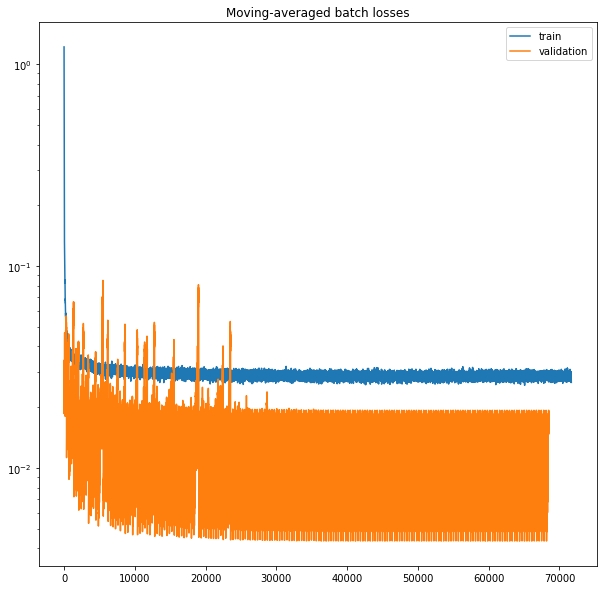

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

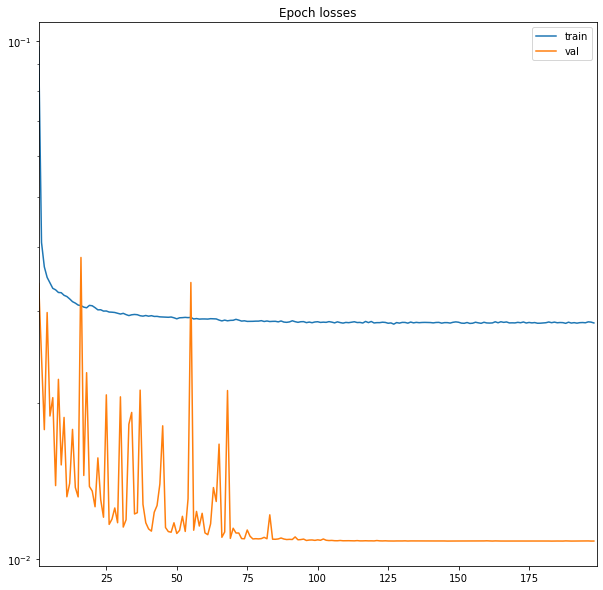

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996541,0.976034,0.975265,0.975649,0.998104,0.952456,carb96558,basic
1,0.989319,0.922195,0.985854,0.952963,0.994398,0.910151,carb71,basic
2,0.978515,0.955171,0.838924,0.893281,0.972670,0.807144,carbRNF,basic
3,0.990578,0.988736,0.915378,0.950643,0.993922,0.905930,SPE_carb10_58_box3,basic
4,0.989077,0.984902,0.902820,0.942076,0.992568,0.890496,SoilAh-1,basic
5,0.995810,0.969284,0.964865,0.967070,0.996611,0.936239,SoilB-2,basic
6,0.988693,0.997442,0.918570,0.956383,0.997523,0.916411,TeTree_subset1,basic
7,0.992625,0.996074,0.927398,0.960510,0.997685,0.924020,TiTree_subset2,basic
8,0.992734,0.971555,0.971690,0.971622,0.997404,0.944810,Urna_22,basic
9,0.991259,0.974066,0.971653,0.972858,0.997881,0.947151,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.9113
Std    IOU: 0.040864
Min    IOU: 0.80714
Median IOU: 0.91641


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): FocalLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0022
Mean 1 loss: 0.0041
Mean of ratios: 0.5553
Ratio of means: 0.5512
